In [6]:
FOLDERNAME = 'Data'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
import os
# sys.path.append('/content/drive/Shared drives/ACMLab Project/{}'.format(FOLDERNAME))

# %cd 

In [7]:
!ls

16zpallnoagi.csv     lightning_logs  tiles_to_income_test.csv	worldelev.npy
get_tile_incomes.py  model.pth	     tiles_to_income_train.csv	ziplatlon.csv
imagery		     pretrained.pth  util.py
images.ipynb	     test_imagery    webmercator.py


In [8]:
# Importing the standard ML libraries...
%load_ext autoreload
%autoreload 2

import pandas as pd                     # to process our data
import matplotlib.pyplot as plt         # graphing
import numpy as np                      # matrices

import torch
import torchvision                      # for MNIST dataset/working with images

import os
from PIL import Image
import cv2

In [33]:
torch.cuda.set_device(0)

In [34]:
tile_incomes_data_train = pd.read_csv('tiles_to_income_train.csv')
msk = np.random.rand(len(tile_incomes_data_train)) < 0.8
train = tile_incomes_data_train[msk]
test = tile_incomes_data_train[~msk]

tile_incomes_data_test = pd.read_csv('tiles_to_income_test.csv')

In [35]:
tiles_to_avg_income_train = {}
for row in train.iterrows():
    tiles_to_avg_income_train[(int(row[1][0]), int(row[1][1]))] = row[1][2]
    
tiles_to_avg_income_test = {}
for row in test.iterrows():
    tiles_to_avg_income_test[(int(row[1][0]), int(row[1][1]))] = row[1][2]

In [36]:
labels = [tiles_to_avg_income_test[key] for key in tiles_to_avg_income_test.keys()] + [tiles_to_avg_income_train[key] for key in tiles_to_avg_income_train.keys()]

In [37]:
train_labels = [tiles_to_avg_income_train[key] for key in tiles_to_avg_income_train.keys()]
test_labels = [tiles_to_avg_income_test[key] for key in tiles_to_avg_income_test.keys()] 

(array([25., 49., 36., 21., 29., 23., 34., 14., 23.,  7.,  0.,  3.,  3.,
         0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  7.,  3.,  2.,  2.,  0.,
         1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,
         5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([ 26.77940638,  38.93114419,  51.08288201,  63.23461982,
         75.38635764,  87.53809545,  99.68983326, 111.84157108,
        123.99330889, 136.14504671, 148.29678452, 160.44852234,
        172.60026015, 184.75199797, 196.90373578, 209.0554736 ,
        221.20721141, 233.35894923, 245.51068704, 257.66242486,
        269.81416267, 281.96590049, 294.1176383 , 306.26937612,
        318.42111393, 330.57285175, 342.72458956, 354.87632738,
        367.02806519, 379.17980301, 391.33154082, 403.48327864,
        415.63501645, 427.78675427, 439.93849208, 452.0902299 ,
        464.24196771, 476.39370552, 488.54544334, 500.69718115,
        512.84891897, 525.00065678, 537.1523946 , 549.30413241,
        561.

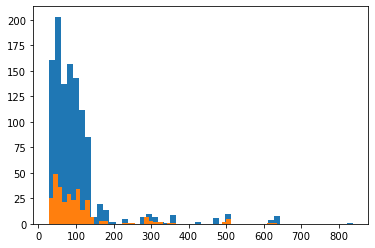

In [38]:
plt.hist(train_labels, bins=50)
plt.hist(test_labels, bins=50)

In [39]:
mean = np.mean(labels)
std = np.std(labels)

In [40]:
mean

103.30363299717398

In [41]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, folder, tiles_to_avg_income, transforms = None):
        self.img_shape = (256,256,3)
        self.img_data = []
        self.label_data = []
        self.length = len(tiles_to_avg_income)
        for tile in tiles_to_avg_income:
            image_name = "/14_" + str(tile[0]) + "_" + str(tile[1]) + ".jpg"
            img = cv2.imread(folder + image_name)     #.flatten()
            self.img_data.append(img)
            self.label_data.append(tiles_to_avg_income[tile])
        self.img_data = np.array(self.img_data).squeeze()
        self.img_data = np.squeeze(self.img_data)
        self.label_data = np.array(self.label_data)
        if (transforms != None):
            self.label_data = np.clip(self.label_data, 0, 500)
        self.label_data -= mean
        self.label_data /= std
        self.images = np.array(self.img_data)
        self.labels = np.array(self.label_data)
        self.transforms = transforms
        
    def __len__(self):
        return self.length # this should return the number of elements in your dataset
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        transform = None
        if (self.transforms != None):
            transform = self.transforms[random.randrange(0,len(self.transforms))]
        if (transform is not None):
            image = transform(Image.fromarray(np.uint8(image)))
            image = np.array(image)
        image = torch.tensor(image, dtype=torch.float32).permute(2,0,1)
        return image, torch.tensor(label, dtype=torch.float32)
        #return image, label # this should return a tuple of (image, label)
                              # where `image` is the image as a tensor
                              # and `label` is the ground truth label as a float

In [42]:
import random

In [43]:
from torchvision.transforms import *

In [44]:
crop = RandomResizedCrop((256,256), scale=(0.2, 1.0))
rotate = RandomAffine(20)
translate = RandomAffine(0,(0.3,0.3))
hflip = RandomHorizontalFlip(p=1.0)
vflip = RandomVerticalFlip(p=1.0)
transforms = [crop, rotate, hflip, vflip, translate, None]
# transforms = [translate, None]

In [45]:
train_dataset = ImageDataset("imagery", tiles_to_avg_income_train, transforms)

In [46]:
test_dataset = ImageDataset("imagery", tiles_to_avg_income_test)

In [47]:
batch_size = 64
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [48]:
import torch.nn as nn
import torch.nn.functional as F

In [49]:
import torch.nn as nn
import torch.nn.functional as F
    
class InceptionBlock(nn.Module):
    def __init__(self, in1, out):
        super(InceptionBlock, self).__init__()
        self.act = nn.PReLU()
        self.convBlock1 = nn.Sequential(
            nn.Conv2d(in1, out, 5, stride = 2,  padding=2),
            nn.BatchNorm2d(out),
            self.act,
            nn.MaxPool2d(2)
        )
        self.convBlock2 = nn.Sequential(
            nn.Conv2d(in1, out, 3, stride = 2,  padding=1),
            nn.BatchNorm2d(out),
            self.act,
            nn.MaxPool2d(2)
        )
        self.convBlock3 = nn.Sequential(
            nn.Conv2d(in1, out, 7, stride = 2,  padding=3),
            nn.BatchNorm2d(out),
            self.act,
            nn.MaxPool2d(2)
        )
    def forward(self, x):
        a = self.convBlock1(x)
        b = self.convBlock2(x)
        c = self.convBlock3(x)
        return a+b+c

class ConvolutionalNeuralNet(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNet, self).__init__()
        self.act = nn.PReLU()
        self.act2 = nn.Sigmoid()
        
        self.convBlock1 = InceptionBlock(3,32)
        self.convBlock2 = InceptionBlock(32,64)
        self.convBlock3 = InceptionBlock(64,128)
        self.convBlock4 = InceptionBlock(128,256)

        self.drop = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.convBlock1(x)
        x = self.convBlock2(x)
        x = self.convBlock3(x)
        x = self.convBlock4(x)
        x = x.view(-1, 256 * 1 * 1)
        x = self.drop(self.act2(self.fc1(x)))
        x = self.drop(self.act2(self.fc2(x)))
        x = self.fc3(x)
        return x.squeeze()

In [50]:
from torchsummary import summary
summary(ConvolutionalNeuralNet(), input_size=(3,256,256), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]           2,432
       BatchNorm2d-2         [-1, 32, 128, 128]              64
             PReLU-3         [-1, 32, 128, 128]               1
             PReLU-4         [-1, 32, 128, 128]               1
             PReLU-5         [-1, 32, 128, 128]               1
             PReLU-6         [-1, 32, 128, 128]               1
         MaxPool2d-7           [-1, 32, 64, 64]               0
            Conv2d-8         [-1, 32, 128, 128]             896
       BatchNorm2d-9         [-1, 32, 128, 128]              64
            PReLU-10         [-1, 32, 128, 128]               1
            PReLU-11         [-1, 32, 128, 128]               1
            PReLU-12         [-1, 32, 128, 128]               1
            PReLU-13         [-1, 32, 128, 128]               1
        MaxPool2d-14           [-1, 32,

In [132]:
cnn_model = ConvolutionalNeuralNet().cuda() # Don't forget to add .to(device=device)
criterion = torch.nn.L1Loss(reduction = 'sum')
optimizer = torch.optim.AdamW(cnn_model.parameters(), lr = 0.001, weight_decay=0.1) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.2, patience = 5, verbose=True)

for epoch in range(100):
    epoch_loss = 0
    cnn_model.train()
    for batch_idx, (images, labels) in enumerate(trainloader):
        images = images.cuda()
        labels = labels.cuda() # Put the labels on GPU as well

        optimizer.zero_grad()                 # resets the information from last time
        pred_y = cnn_model(images)            # calculates the predictions
        loss = criterion(pred_y, labels)      # calculates the loss
        loss.backward()                       # gradient descent, part 1
        optimizer.step()                      # gradient descent, part 2
        epoch_loss += loss.item()
    epoch_loss /= len(train_dataset)
    
    cnn_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(testloader):       
            output = cnn_model(images.cuda())
            labels = labels.cuda()
            loss = criterion(output, labels)
            val_loss += loss.item()
        val_loss /= len(test_dataset)
        
    print(f"Epoch {epoch}: {epoch_loss} Val: {val_loss}")
    scheduler.step(val_loss)

Epoch 0: 0.4814772550300632 Val: 0.5419065651226369
Epoch 1: 0.4847436451591184 Val: 0.5169670606229085
Epoch 2: 0.48007071371035726 Val: 0.5034466473315763
Epoch 3: 0.4736311899706922 Val: 0.5025366890552507
Epoch 4: 0.4665974689706024 Val: 0.5442697765884139
Epoch 5: 0.4652449432509897 Val: 0.49167734608308444
Epoch 6: 0.4619477113800733 Val: 0.4948506339011339
Epoch 7: 0.45015162309723583 Val: 0.5846555013298581
Epoch 8: 0.45456826419573726 Val: 0.5277107193201476
Epoch 9: 0.4513655914854041 Val: 0.5189569427698546
Epoch 10: 0.43868932852296016 Val: 0.5106009883685324
Epoch 11: 0.4433459598387303 Val: 0.6135136535956998
Epoch    12: reducing learning rate of group 0 to 2.0000e-04.
Epoch 12: 0.4327781052867393 Val: 0.4623156993462364
Epoch 13: 0.4281290131299485 Val: 0.6019314547854479
Epoch 14: 0.427952431135648 Val: 0.47313800199853684
Epoch 15: 0.42124077065643173 Val: 0.4642666826476009
Epoch 16: 0.42320397210228067 Val: 0.4580308243683174
Epoch 17: 0.42229916782122556 Val: 0.447

### Create Graph

In [1]:
lines = '''Epoch 0: 0.4814772550300632 Val: 0.5419065651226369
Epoch 1: 0.4847436451591184 Val: 0.5169670606229085
Epoch 2: 0.48007071371035726 Val: 0.5034466473315763
Epoch 3: 0.4736311899706922 Val: 0.5025366890552507
Epoch 4: 0.4665974689706024 Val: 0.5442697765884139
Epoch 5: 0.4652449432509897 Val: 0.49167734608308444
Epoch 6: 0.4619477113800733 Val: 0.4948506339011339
Epoch 7: 0.45015162309723583 Val: 0.5846555013298581
Epoch 8: 0.45456826419573726 Val: 0.5277107193201476
Epoch 9: 0.4513655914854041 Val: 0.5189569427698546
Epoch 10: 0.43868932852296016 Val: 0.5106009883685324
Epoch 11: 0.4433459598387303 Val: 0.6135136535956998
Epoch    12: reducing learning rate of group 0 to 2.0000e-04.
Epoch 12: 0.4327781052867393 Val: 0.4623156993462364
Epoch 13: 0.4281290131299485 Val: 0.6019314547854479
Epoch 14: 0.427952431135648 Val: 0.47313800199853684
Epoch 15: 0.42124077065643173 Val: 0.4642666826476009
Epoch 16: 0.42320397210228067 Val: 0.4580308243683174
Epoch 17: 0.42229916782122556 Val: 0.44751608982021085
Epoch 18: 0.4180434701688621 Val: 0.4487593784267178
Epoch 19: 0.4153541402431882 Val: 0.44981093292757107
Epoch 20: 0.41185177858634914 Val: 0.5178853904021071
Epoch 21: 0.4152076361959825 Val: 0.5231652276100965
Epoch 22: 0.4135700097533085 Val: 0.4455852768933814
Epoch 23: 0.41085602200084737 Val: 0.5409121399446559
Epoch 24: 0.412087420818517 Val: 0.6292602063852772
Epoch 25: 0.4142619509333452 Val: 0.4468383984354169
Epoch 26: 0.4077300854327967 Val: 0.685072501771686
Epoch 27: 0.40881721684750955 Val: 0.46972337273607484
Epoch 28: 0.4133657891654113 Val: 0.5064313387301188
Epoch    29: reducing learning rate of group 0 to 4.0000e-05.
Epoch 29: 0.4013686227156977 Val: 0.4436752918230389
Epoch 30: 0.40370565166387856 Val: 0.44122886657714844
Epoch 31: 0.3977505688175492 Val: 0.4413850022664249
Epoch 32: 0.4016878239242485 Val: 0.4439276216786876
Epoch 33: 0.40391856822197747 Val: 0.4414270680919035
Epoch 34: 0.39493607320058505 Val: 0.4414205258209958
Epoch 35: 0.3942470567643375 Val: 0.4490568727356582
Epoch 36: 0.39271359978235354 Val: 0.44187735860258237
Epoch    37: reducing learning rate of group 0 to 8.0000e-06.
Epoch 37: 0.3968207376420231 Val: 0.4392501030358845
Epoch 38: 0.39645614110835464 Val: 0.4391535410702025
Epoch 39: 0.3980788893763795 Val: 0.43982096987779634
Epoch 40: 0.3974194069079754 Val: 0.4433883660482465
Epoch 41: 0.39444722402256166 Val: 0.4401729766012459
Epoch 42: 0.38867057834505503 Val: 0.44049677669798554
Epoch 43: 0.39395329856017247 Val: 0.4413787008552421
Epoch 44: 0.39766851091598715 Val: 0.4402423474568963
Epoch    45: reducing learning rate of group 0 to 1.6000e-06.
Epoch 45: 0.39330128126614833 Val: 0.44034749574628707
Epoch 46: 0.3961403372041848 Val: 0.44081430467729277
Epoch 47: 0.3936155259341937 Val: 0.4400029166159776
Epoch 48: 0.3973903874110748 Val: 0.439359703975326
Epoch 49: 0.3926104173531981 Val: 0.4408456294609825
Epoch 50: 0.39673998537619554 Val: 0.44128059934023706
Epoch    51: reducing learning rate of group 0 to 3.2000e-07.
Epoch 51: 0.3906603586513365 Val: 0.44049532502991345
Epoch 52: 0.3975156159678917 Val: 0.4406412209260179
Epoch 53: 0.3993313733772312 Val: 0.4401069484879946
Epoch 54: 0.39798699922091224 Val: 0.43914222717285156
Epoch 55: 0.3924389244729628 Val: 0.44017408325403623
Epoch 56: 0.3955168899399283 Val: 0.44000821878478796
Epoch    57: reducing learning rate of group 0 to 6.4000e-08.
Epoch 57: 0.3931662230213661 Val: 0.43952271718620844
Epoch 58: 0.39858244566639445 Val: 0.43953365026480506
Epoch 59: 0.39196038524131604 Val: 0.44003809515526676
Epoch 60: 0.3972783204151376 Val: 0.4405898527073779
Epoch 61: 0.3945478772903237 Val: 0.44132020449068765
Epoch 62: 0.3935054445480552 Val: 0.44151154801300363
Epoch    63: reducing learning rate of group 0 to 1.2800e-08.
Epoch 63: 0.3937180634571298 Val: 0.44096562317207
Epoch 64: 0.3981032315925632 Val: 0.4399217599081098
Epoch 65: 0.39480492886940993 Val: 0.44049454711809904
Epoch 66: 0.3930323322792224 Val: 0.44116347641668224
Epoch 67: 0.3920409788465286 Val: 0.44082539724408565
Epoch 68: 0.3970975251475792 Val: 0.4419872199309157
Epoch    69: reducing learning rate of group 0 to 2.5600e-09.
Epoch 69: 0.39164857222894917 Val: 0.44251386297440776
Epoch 70: 0.3975617019584895 Val: 0.440812179252963
Epoch 71: 0.3980888494996212 Val: 0.4409784180312433
Epoch 72: 0.39724715279891354 Val: 0.43987478575201977
Epoch 73: 0.3966087392627391 Val: 0.4404625518330128
Epoch 74: 0.39383248384757963 Val: 0.4407488722036316
Epoch 75: 0.3929035853911943 Val: 0.4400257722509599
Epoch 76: 0.3883319136273166 Val: 0.4407056997253626
Epoch 77: 0.39490118668218366 Val: 0.4412813154096896
Epoch 78: 0.39718651621865586 Val: 0.44160644023491663
Epoch 79: 0.38976764037470113 Val: 0.4421230225025997
Epoch 80: 0.39240874217764676 Val: 0.44226424116323426
Epoch 81: 0.39245723758577766 Val: 0.44159054674793025
Epoch 82: 0.39349311606231824 Val: 0.44041599104428863
Epoch 83: 0.393712316607146 Val: 0.44083803912478503
Epoch 84: 0.39111898276837953 Val: 0.44044784311548435
Epoch 85: 0.38606545999980296 Val: 0.4396094624906677
Epoch 86: 0.39731458954746945 Val: 0.43952296781051686
Epoch 87: 0.3969895683596487 Val: 0.4396568858175961
Epoch 88: 0.3912089104075068 Val: 0.44001415890638335
Epoch 89: 0.3965822100104772 Val: 0.4401777059144941
Epoch 90: 0.40041353028985954 Val: 0.4403566256318076
Epoch 91: 0.390365154112401 Val: 0.440845046840837
Epoch 92: 0.3892532947352114 Val: 0.44055410782224896
Epoch 93: 0.3967417267940504 Val: 0.44038058791958024
Epoch 94: 0.3968723425416134 Val: 0.4401383709175188
Epoch 95: 0.3938552411682403 Val: 0.44040155248023544
Epoch 96: 0.3937801326871453 Val: 0.4408225687697479
Epoch 97: 0.394651409542614 Val: 0.44071476776852136
Epoch 98: 0.3973333162042592 Val: 0.44068931475434286
Epoch 99: 0.39451572691913145 Val: 0.4402132782919822'''

In [56]:
train = []
val = []
for line in lines.split("\n"):
    if ("reducing" in line):
        continue
    line = line.split(" ")
    train.append(float(line[2]))
    val.append(float(line[4]))

Text(0.5, 0, 'Epoch')

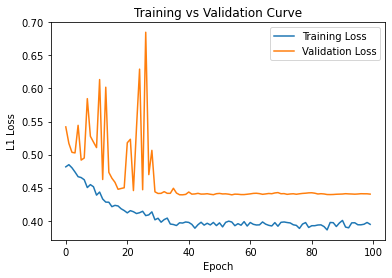

In [60]:
plt.plot(np.array(train))
plt.plot(np.array(val))
plt.title("Training vs Validation Curve")
plt.legend(["Training Loss", "Validation Loss"])
plt.ylabel("L1 Loss")
plt.xlabel("Epoch")

### Testing

In [51]:
cnn_model = torch.load("model.pth") 

In [52]:
errs = []
with torch.no_grad():
    cnn_model.eval()
    for batch_idx, (images, labels) in enumerate(trainloader):       
        output = cnn_model(images.cuda()) * std + mean
        labels = labels * std + mean
        error = (abs(output.squeeze().cpu() - labels)).squeeze().numpy()
        errs.append(error)
totalErrs = []
for err in errs:
    for i in err:
        totalErrs.append(i)
print(np.mean(totalErrs))

34.74497


In [53]:
errs = []
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(testloader):  
        labels = labels * std + mean
        error = (abs(labels.mean() - labels)).squeeze().numpy()
        errs.append(error)
totalErrs = []
for err in errs:
    for i in err:
        totalErrs.append(i)
print(np.mean(totalErrs))

60.69643


In [54]:
errs = []
with torch.no_grad():
    cnn_model.eval()
    for batch_idx, (images, labels) in enumerate(testloader):       
        output = cnn_model(images.cuda()) * std + mean
        labels = labels * std + mean
        error = (abs(output.squeeze().cpu() - labels)).squeeze().numpy()
        errs.append(error)
totalErrs = []
for err in errs:
    for i in err:
        totalErrs.append(i)
print(np.mean(totalErrs))

40.11769


In [128]:
torch.save(cnn_model, "model.pth")

/data/Jeremy/anaconda3/envs/jeremy/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ConvolutionalNeuralNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/data/Jeremy/anaconda3/envs/jeremy/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type InceptionBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Pretrained

In [45]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)

In [46]:
for param in resnet18.parameters():
    param.requires_grad = False

In [47]:
resnet18.fc = nn.Sequential(nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 1))

In [52]:
params_to_update = resnet18.parameters()
print("Params to learn:")
params_to_update = []
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.0.weight
	 fc.0.bias
	 fc.2.weight
	 fc.2.bias


In [58]:
resnet18 = resnet18.cuda()
criterion = torch.nn.L1Loss(reduction = 'sum')
optimizer = torch.optim.Adam(params_to_update, lr = 0.001, weight_decay=0.01) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.2, patience = 5, verbose=True)

for epoch in range(40):
    epoch_loss = 0
    resnet18.train()
    for batch_idx, (images, labels) in enumerate(trainloader):
        images = images.cuda()
        labels = labels.cuda() # Put the labels on GPU as well
        labels = torch.clamp(labels, -2, 3)

        optimizer.zero_grad()                 # resets the information from last time
        pred_y = resnet18(images).squeeze()            # calculates the predictions
        loss = criterion(pred_y, labels)      # calculates the loss
        loss.backward()                       # gradient descent, part 1
        optimizer.step()                      # gradient descent, part 2
        epoch_loss += loss.item()
    epoch_loss /= len(train_dataset)
    
    resnet18.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(testloader):       
            output = resnet18(images.cuda()).squeeze()
            labels = labels.cuda()
            loss = criterion(output, labels)
            val_loss += loss.item()
        val_loss /= len(test_dataset)
        
    print(f"Epoch {epoch}: {epoch_loss} Val: {val_loss}")
    scheduler.step(val_loss)

Epoch 0: 0.357467125753036 Val: 0.38564424445159246
Epoch 1: 0.3552654054429796 Val: 0.40567959486132993
Epoch 2: 0.34752213849802704 Val: 0.38434275049362737
Epoch 3: 0.34073979766280565 Val: 0.39661747347699466
Epoch 4: 0.34897104562695486 Val: 0.4113430019712796
Epoch 5: 0.3364511621061456 Val: 0.3998685683647211
Epoch 6: 0.34450908607065783 Val: 0.3896087207933412
Epoch 7: 0.3459161744967129 Val: 0.4147815634734439
Epoch 8: 0.3399242471765589 Val: 0.40599924630492273
Epoch     9: reducing learning rate of group 0 to 2.0000e-04.
Epoch 9: 0.3319251255593813 Val: 0.38350708815303164
Epoch 10: 0.3236929298077942 Val: 0.39061297987499377
Epoch 11: 0.3215346849364158 Val: 0.3859180290333546
Epoch 12: 0.3227650787044034 Val: 0.3904618555611938
Epoch 13: 0.3144740360334016 Val: 0.3893326111953624
Epoch 14: 0.32401554588708087 Val: 0.3996538959280418
Epoch 15: 0.3274257977803548 Val: 0.3854815768499444
Epoch    16: reducing learning rate of group 0 to 4.0000e-05.
Epoch 16: 0.319010806882612

In [59]:
errs = []
with torch.no_grad():
    resnet18.eval()
    for batch_idx, (images, labels) in enumerate(testloader):       
        output = resnet18(images.cuda()) * std + mean
        labels = labels * std + mean
        error = (abs(output.squeeze().cpu() - labels)).squeeze().numpy()
        errs.append(error)
totalErrs = []
for err in errs:
    for i in err:
        totalErrs.append(i)
print(np.mean(totalErrs))

37.054287


In [55]:
torch.save(resnet18, "pretrained.pth")